## Importing packages

In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import simpy
import networkx as nx  
import numpy as np
import pandas as pd
import yaml as yaml
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import folium

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model

#import testopentnsim

# spatial libraries 
import shapely.geometry
import shapely.wkt
import pyproj
import shapely.geometry
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate system
geod = pyproj.Geod(ellps="WGS84")


In [2]:
info =pd.read_csv('info_volkerak_010819_311019.csv')
info.drop(columns={'Unnamed: 0'}, inplace=True)

ships = np.loadtxt('ships_cases_2v2.txt')

ships_nodes = pd.read_csv('ships_at_node.csv', index_col=0)

wlev = pd.read_csv('waterstanden.csv', delimiter=';', encoding='cp1252')
wlev = wlev[wlev['GROOTHEID_OMSCHRIJVING'] == 'Waterhoogte']
wlev = wlev[wlev['LOCATIE_CODE'] == 'RAKND']
wlev['timestamp'] = (pd.to_datetime(wlev['WAARNEMINGDATUM'], format='%d-%m-%Y', utc=True) + pd.to_timedelta(wlev['WAARNEMINGTIJD (MET/CET)']))
wlev.sort_values('timestamp', inplace=True)
wlev.reset_index(drop=True, inplace=True)

C:\Users\freek\AppData\Local\Temp\ipykernel_1668\714678796.py:8: DtypeWarning:

Columns (46,47,49) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
ships = ships

In [4]:
%%capture --no-display
ship_nodes_1 = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
info_1 = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

for case in ships:
    for i, ind in enumerate(case):
        if any(info['index'] == ind):
            info_1[i] = info_1[i].append(info[info['index'] == ind])
            ship_nodes_1[i] = ship_nodes_1[i].append(ships_nodes.loc[ind])


In [5]:
#ships_nodes = pd.read_csv('ships_at_node.csv', index_col=0)

distance = []
sog_start = []
t_start = []
reduction = []
enter = [1, 21]
w_a = [8, 14]
l_a = [10, 12]
lock = [10, 12]

for i, df in enumerate(ship_nodes_1):
    df.reset_index(inplace=True, drop=True)
    sog_start.append([])
    t_start.append([])
    reduction.append([])
    for j, r in df.iterrows():
        
        if pd.to_datetime(r[0]) < pd.to_datetime(r[20]):
            d = 0
        else:
            d = 1

        t0 = pd.to_datetime(r[enter[d] - 1])
        v0 = r[enter[d] + 20]
        v1 = r[w_a[d] + 20]
        v2 = r[l_a[d] + 20]
        
        sog_start[i].append(v0)
        t_start[i].append(t0)
        reduction[i].append([v1 / v0, v2 / v0])
    

waterlevel = []

for i, df in enumerate(info_1):
    waterlevel.append([])
    for j, r in df.iterrows():
        enter = pd.to_datetime(r['enter time'], utc=True)

        waterlevel[i].append(wlev.loc[np.argmin(abs(wlev['timestamp'] - enter))]['NUMERIEKEWAARDE'] / 100)

In [6]:
reduction_mean = []

for r in reduction:
    reduction_mean.append([np.mean(np.array(r)[:,0]), np.mean(np.array(r)[:,1])])

reduction_mean

[[0.6339950615190906, 0.3941628149955577],
 [0.6897812601799518, 0.22392306428530612],
 [0.6834540457970683, 0.39837169357974583],
 [0.6976074043143485, 0.21264161091403339]]

## Creating network

In [7]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
#fig, ax = plt.subplots(1, 1, figsize=(10, 10))

coords = [[4.431711765453108,51.69919249464677],
          [4.428674043520671,51.69925058643445],
          [4.426520307378901,51.69909734687116],
          [4.424980827084277,51.69876203857485],
          [4.423697201845156,51.69822379606292],
          [4.42074464145006,51.69663454747826],
          [4.418738102576006,51.69556033504191],
          [4.417414946619205,51.69484342434918],
          [4.414052050039478,51.69302665557799],
          [4.411260559026335,51.69152063195392],
          [4.409375907761905,51.69049721074719],
          [4.407558470987929,51.68950444222966],
          [4.403773394426889,51.68748639488896],
          [4.400388700536705,51.68570503952014],
          [4.399705360113479,51.68532707785089],
          [4.396838866281541,51.68379266841475],
          [4.393109213885338,51.68180281425153],
          [4.390189828820366,51.68013249657422],
          [4.388336842048544,51.67879411774161],
          [4.387028491268927,51.6776897747193],
          [4.385381824047309,51.67609098108045]]

for d in range(len(coords)):
    data_node = {"env": [],
                 "name": "Node " + str(d+1),
                 "geometry": shapely.geometry.Point(coords[d][0], coords[d][1])}
    node = Node(**data_node)
    nodes.append(node)

for i in range(2):
    if i == 0:
        for j in range(len(nodes)-1):
            path.append([nodes[j], nodes[j+1]])
    if i == 1:
        for j in range(len(nodes)-1):
            path.append([nodes[j+1], nodes[j]])
    
FG = nx.DiGraph()

map = folium.Map(location=[51.694, 4.415], zoom_start=14)
line = []
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)
    
    folium.CircleMarker((node.geometry.y, node.geometry.x), popup=node.name, fill=True).add_to(map)
    line.append((node.geometry.y, node.geometry.x))
    
folium.PolyLine(line).add_to(map)

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

#nx.draw(FG, positions,ax=ax)

map

## Simulation setup

In [8]:
# Start simpy environment (at a given date and time)
def set_simulation(FG, start):
    simulation_start = start
    sim = model.Simulation(simulation_start,FG)
    env = sim.environment
    env.FG = FG
    
    return sim, env

## Fleet

In [9]:
def add_vessel(sim, env, n, start_times, v_enter, speed_reduction):

    Vessel = type('Vessel', 
              (core.Identifiable, core.HasLineUpArea, core.HasWaitingArea, core.HasSpeedReduction, core.HasLock, core.Movable, core.Routeable, core.VesselProperties, core.ExtraMetadata), {})

    start_point = 'Node 1' 
    end_point = 'Node 21'  
    
    
    operator = [[abs(start_times[1] - start_times[0]), abs(start_times[3] - start_times[2])], [0, 0]]
    
    def data_vessel(num, t0, v, sp, operator):
        if (v > 0) == False:
            v = 4
            
        if num == 1:
            d_v = {"env": env,
                               "name": "Vessel",
                               "route": nx.dijkstra_path(FG, start_point, end_point, weight='length'),
                               "geometry": env.FG.nodes[start_point]['geometry'],
                               "v": v,
                               "lock_name": 'Volkeraksluizen_1',
                               "type": 'CEMT - Va',
                               "B": 11.40,
                               "H_e": 7.10,
                               "H_f": 5.40,
                               "T_e": 1.8,
                               "T_f": 3.5,
                               "L": 135.0,
                               "start_time": t0, "speed_reduction": sp, "operator_waiting": operator}
        elif num == 2:
            d_v = {"env": env,
                               "name": "Vessel",
                               "route": nx.dijkstra_path(FG, end_point, start_point, weight='length'),
                               "geometry": env.FG.nodes[end_point]['geometry'],
                               "v": v,
                               "lock_name": 'Volkeraksluizen_1',
                               "type": 'CEMT - Va',
                               "B": 11.40,
                               "H_e": 7.10, 
                               "H_f": 5.40,
                               "T_e": 1.8,
                               "T_f": 3.5,
                               "L": 135.0,
                               "start_time": t0, "speed_reduction": sp, "operator_waiting": operator}
            
        return d_v
    
    for i in range(n):
        t1 = start_times[i]
        t2 = start_times[i + n]
        
        v1 = v_enter[i]
        v2 = v_enter[i + n]
        
        sp1 = speed_reduction[i]
        sp2 = speed_reduction[i + n]
        
        for j, sp in enumerate(sp1):
            if sp == 0:
                sp1[j] = 1
        
        for j, sp in enumerate(sp2):
            if sp == 0:
                sp2[j] = 1
        
        vessel = Vessel(**data_vessel(1, t1, v1, sp1, operator[i][0]))
        sim.add_vessels(start_point,end_point,[],vessel)

        vessel = Vessel(**data_vessel(2, t2, v2, sp2, operator[i][1]))
        sim.add_vessels(end_point,start_point,[],vessel)
    
    return sim


## Infrastructure

In [10]:
def infrastructure(env, water_level, wlev_dif, simulation_start):
    waiting_area_1 = core.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                            name = 'Volkeraksluizen_1', node = "Node 6")

    lineup_area_1 = core.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                              name = 'Volkeraksluizen_1', node = "Node 8", lineup_length = 200)

    lock_1 = core.IsLock(env = env, nr_resources = 100, priority = True, name = 'Volkeraksluizen_1',            
                             node_1 = "Node 10", node_2 = "Node 11", node_3 = "Node 12",
                             lock_length = 330, lock_width = 24, lock_depth = 4.5, 
                             doors_open = 2.5 * 60, doors_close = 1.6 * 60, wlev_dif = wlev_dif, disch_coeff = 0.75,
                             grav_acc = 9.81, opening_area = 8.0, opening_time = 2 * 60,
                             simulation_start = simulation_start, operating_time = 25*60)

    waiting_area_2 = core.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                                name = "Volkeraksluizen_1", node = "Node 16")

    lineup_area_2 = core.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                              name = "Volkeraksluizen_1", node = "Node 14", lineup_length = 200)
    
    speed_reduction_1 = core.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                            name = 'Volkeraksluizen_1', node = "Node 2")
    
    speed_reduction_2 = core.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                            name = 'Volkeraksluizen_1', node = "Node 20")
    
    
    lock_1.water_level = "Node 10"
    env.FG.nodes["Node 11"]["Lock"] = [lock_1]

    env.FG.nodes["Node 6"]["Waiting area"] = [waiting_area_1]
    env.FG.nodes["Node 8"]["Line-up area"] = [lineup_area_1]

    env.FG.nodes["Node 16"]["Waiting area"] = [waiting_area_2]
    env.FG.nodes["Node 14"]["Line-up area"] = [lineup_area_2]
    
    env.FG.nodes["Node 2"]["Speed reduction"] = [speed_reduction_1]
    env.FG.nodes["Node 20"]["Speed reduction"] = [speed_reduction_2]
       
    return env

## Information from output

In [11]:
def waiting_times(vessels):
    
    waiting_to_waiting_area = []
    waiting_in_waiting_area = []
    waiting_in_lineup_area = []
    waiting_in_lock = []
    total_waiting_time = np.zeros(len(vessels))
    passage_time = np.zeros(len(vessels))

    for v in range(0,len(vessels)):
        for t in range(0,len(vessels[v].log["Message"])-1):
            if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop":
                waiting_to_waiting_area.append(vessels[v].log["Value"][t]/60)
            if vessels[v].log["Message"][t] == "Waiting in waiting area stop":
                waiting_in_waiting_area.append(vessels[v].log["Value"][t]/60)
            if vessels[v].log["Message"][t] == "Waiting in line-up area stop":
                waiting_in_lineup_area.append(vessels[v].log["Value"][t]/60)
            if vessels[v].log["Message"][t] == "Passing lock stop":
                waiting_in_lock.append(vessels[v].log["Value"][t]/60)

    for v in range(len(vessels)):
        for t in range(0,len(vessels[v].log["Message"])-1):
            if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop" or vessels[v].log["Message"][t] == "Waiting in waiting area stop" or vessels[v].log["Message"][t] == "Waiting in line-up area stop" or  vessels[v].log["Message"][t] == "Passing lock stop": 
                total_waiting_time[v] += ((vessels[v].log["Value"][t]/60))
                
        passage_time[v] = (vessels[v].log['Timestamp'][-1] - vessels[v].log['Timestamp'][0]).seconds / 60
                
    return waiting_to_waiting_area, waiting_in_waiting_area, waiting_in_lineup_area, waiting_in_lock, total_waiting_time, passage_time


## Adding generator to simulation

In [12]:
#%%capture --no-display

def run_simulation(FG, start_time, v_enter, speed_reduction, n, wlev_dif = 2, water_level="Node 10", duration=24*60*60):

    simulation_start = start_time[0]
    
    start_times = [0] #chronological -> direction [1, 2, 1, 2 ...]
    
    for t in start_time[1:]:
        start_times.append((t - start_time[0]).seconds)
        
    sim, env = set_simulation(FG, simulation_start)
    
    sim = add_vessel(sim, env, n, start_times, v_enter, speed_reduction)

    env = infrastructure(env, water_level, wlev_dif, simulation_start)
    
    for v in env.vessels:
        print(v.id,v.route[0], v.v)
    
    sim.run(duration = duration)
    
    return sim

## Run simulation

In [13]:
#start_times_ais = pd.read_csv('start_times.csv', usecols=[1,2])
start_times_ais = t_start
v_start_ais = sog_start

for i in range(4):
    start_times_ais[i] = pd.to_datetime(start_times_ais[i])

#v_start_ais = pd.read_csv('entering_speed.csv', usecols=[1,2])
speed_reduction_ais = reduction[:len(start_times_ais)]

waterlevel_ais = waterlevel[:len(start_times_ais)]

In [14]:
%%time
%%capture --no-display

pass_time = []
vessels = []

n = 2
for i in range(len(ships)):
    start_time = []
    v_start = []
    speed_reduction = reduction_mean
    
    for j in range(2 * n):
        start_time.append(start_times_ais[j][i])
        v_start.append(v_start_ais[j][i])
        #speed_reduction.append(speed_reduction_ais[j][i])
    
    print('start time', start_time)
    print('v_start', v_start)
               
    wlev_d = float(waterlevel_ais[0][i])
    
    sim = run_simulation(FG, start_time, v_start, speed_reduction, n=2, wlev_dif = wlev_d)
    vessels_run = sim.environment.vessels #extract vessels (entitie) from environment. It collects info while it moves through the network. That info is stored in the log file. The log file has 
    
    _, _, _, _, _, passage_time = waiting_times(vessels_run)
    
    
    env = sim.environment
    pass_time.append(passage_time)
    vessels.append(vessels_run)


CPU times: total: 3min 13s
Wall time: 5min 32s


In [15]:
pd.DataFrame(vessels[0][3].log)


C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,Message,Timestamp,Value,Geometry
0,Sailing from node Node 21 to node Node 20 start,2019-08-04 10:06:49.000000,9.000000,POINT (4.385381824047309 51.67609098108045)
1,Sailing from node Node 21 to node Node 20 stop,2019-08-04 10:07:12.469531,9.000000,POINT (4.387028491268927 51.6776897747193)
2,Sailing from node Node 20 to node Node 19 start,2019-08-04 10:07:12.469531,6.278467,POINT (4.387028491268927 51.6776897747193)
3,Sailing from node Node 20 to node Node 19 stop,2019-08-04 10:07:36.774960,6.278467,POINT (4.388336842048544 51.67879411774161)
4,Sailing from node Node 19 to node Node 18 start,2019-08-04 10:07:36.774960,6.278467,POINT (4.388336842048544 51.67879411774161)
5,Sailing from node Node 19 to node Node 18 stop,2019-08-04 10:08:08.067737,6.278467,POINT (4.390189828820366 51.68013249657422)
6,Sailing from node Node 18 to node Node 17 start,2019-08-04 10:08:08.067737,6.278467,POINT (4.390189828820366 51.68013249657422)
7,Sailing from node Node 18 to node Node 17 stop,2019-08-04 10:08:51.776549,6.278467,POINT (4.393109213885338 51.68180281425153)
8,Sailing from node Node 17 to node Node 16 start,2019-08-04 10:08:51.776549,6.278467,POINT (4.393109213885338 51.68180281425153)
9,Sailing from node Node 17 to node Node 16 stop,2019-08-04 10:09:45.919178,6.278467,POINT (4.396838866281541 51.68379266841475)


## Time - Distance diagram

In [16]:
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(orig[0], orig[1], 
                         dest[0], dest[1])[2]
    
    return distance

In [17]:
def vessel_path(vessels):

    vessel_path_x = []
    vessel_path_t = []
    origin = 'Node 1'
    destination = 'Node 21'
    
    env = vessels[0].env
    
    v0 = pd.DataFrame.from_dict(vessels[0].log['Timestamp'])
    simulation_start = min(v0[0])
    
    vessel_path_x0 = (vessels[0].log["Geometry"][0].x,vessels[0].log['Geometry'][0].y)
    vessel_path_t0 = simulation_start.timestamp()
    
    for v in range(0,len(vessels)):
        vessel_path_xt = []
        vessel_path_tt = []
        vessel = pd.DataFrame.from_dict(vessels[v].log['Timestamp'])
        vessel_timestamp = vessel[0]
        
        for t in range(0,len(vessels[v].log["Message"])):  
            vessel_path_xt.append(calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessel_timestamp[t].timestamp()-vessel_path_t0)
            
            
        vessel_path_x.append(vessel_path_xt)
        vessel_path_t.append(vessel_path_tt)
    return vessel_path_x, vessel_path_t

In [18]:
def draw_t_d(ax, vessels):
    
    FG = vessels[0].env.FG
    
    vessel_path_x0 = (FG.nodes['Node 1']['geometry'].x,FG.nodes['Node 1']['geometry'].y)
    
    # plot waiting, line up and lock areas
    nodes = ["Node 6", "Node 8", "Node 9", "Node 10", "Node 12", "Node 13", "Node 14", "Node 16"]
    nodes = FG.nodes
    x_ticks = []
    x_labels = []
    
    for node in nodes:
        x = calculate_distance(vessel_path_x0,(FG.nodes[node]['geometry'].x,FG.nodes[node]['geometry'].y))
        ax.axvline(x, color = 'k', linestyle = '--', linewidth = 1.0)
        x_ticks.append(x)
    
    x_chamber = [x_ticks[3], x_ticks[4]]
    
    for x in x_ticks:
        x_labels.append(round(min([abs(x - x_chamber[0]), abs(x - x_chamber[1])])))
    
    vessel_path_x, vessel_path_t = vessel_path(vessels)
    
    
    for v in reversed(range(0,len(vessels))):
        ax.plot(vessel_path_x[v],vessel_path_t[v], label='OpenTNSim')
    
    ylim = [-500, ax.get_ylim()[1] + 500]
    
    ax.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 11"]['geometry'].x,FG.nodes["Node 11"]['geometry'].y)),1.1*ylim[0],'lock \n chamber',horizontalalignment = 'center')
    ax.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y))-
             0.5*calculate_distance((FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y),(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y)),1.1*ylim[0],'line-up \n area',horizontalalignment = 'center')
    ax.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y))+
             0.5*calculate_distance((FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y),(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)),1.1*ylim[0],'line-up \n area',horizontalalignment = 'center')
    ax.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 16"]['geometry'].x,FG.nodes["Node 16"]['geometry'].y)),1.1*ylim[0],'waiting \n area',horizontalalignment = 'center')
    ax.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 6"]['geometry'].x,FG.nodes["Node 6"]['geometry'].y)),1.1*ylim[0],'waiting \n area',horizontalalignment = 'center')

    #ax.title("Tracking diagram for vessels passing the lock", fontweight='bold', pad = 32)
    #ax.xlabel("Distance [m]")
    #ax.xlim([0,0.95*ax.get_xlim()[1]])
    #ax.ylim([0,ax.get_ylim()[1]])
    #ax.ylabel("Time [s]")
    
    ax.set(xlabel="Distance to lock [m]", ylabel='Time [s]', xlim=[0,0.95*ax.get_xlim()[1]], ylim=ylim)#,xticks=x_ticks, xticklabels=x_labels)

    ax.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y)), 
              calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y))],
             [ylim[0], ylim[1], ylim[1], ylim[0]],'lightgrey')

    ax.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y)), 
              calculate_distance(vessel_path_x0,(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y))],
             [ylim[0], ylim[1], ylim[1], ylim[0]],'lightgrey')

    ax.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)), 
              calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y))],
             [ylim[0], ylim[1], ylim[1], ylim[0]],'lightgrey')
    
    ax.invert_yaxis()
    
    
    return ax

In [19]:
def draw_t_d_ais(ax, ship_nodes_1, n, run, FG):
    t0 = min(pd.to_datetime(ship_nodes_1[0].loc[run][0:21]))
    
    for i in range(n):
    
        s1 = ship_nodes_1[i].reset_index(drop=True)
        s2 = ship_nodes_1[i+n].reset_index(drop=True)

        ships = [s1.loc[run], s2.loc[run]]
        
        if pd.to_datetime(ships[0].iloc[0]) < pd.to_datetime(ships[0].iloc[20]):
            c = np.arange(0, 21, 1)
        else:
            c = np.arange(20, -1, -1)

        for s in ships:
            d = []
            t = []

            p0 = FG.nodes['Node 1']['geometry']

            for j, node in enumerate(FG.nodes):
                p1 = FG.nodes[node]['geometry']
                _,_, dis = geod.inv(p0.x, p0.y, p1.x, p1.y)

                d.append(dis)

                t.append((pd.to_datetime(s.iloc[c[j]]) - t0).seconds)

            ax.plot(d, t, label='AIS')

    
    return ax

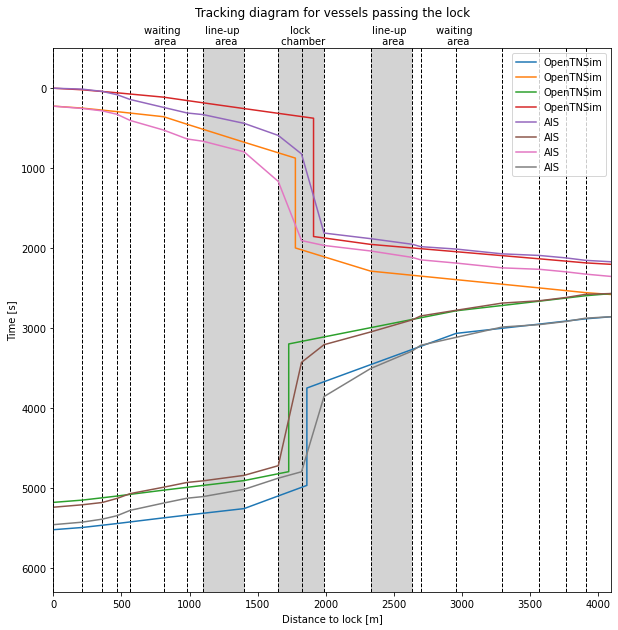

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
run = 51
n = 2
FG = vessels[run][0].env.FG
ax = draw_t_d(ax, vessels[run])
ax = draw_t_d_ais(ax, ship_nodes_1, n, run, FG)
plt.title("Tracking diagram for vessels passing the lock", pad=32);
ax.legend()

## AIS Comparison

In [21]:
# Get passage time for two given nodes

def node_times(vessels, node_1, node_2):
    '''format node_1 and node_2 is [1, 21], with corresponding nodes for both directions.'''
    
    node_time = []
    
    for n, v in enumerate(vessels):
        log = pd.DataFrame(v.log)
        try:
            i = 0
            t1 = log[log['Message'] == f'Sailing from node Node {node_1[i]} to node Node {node_1[i] + 1} start']['Timestamp']
            t1 = t1.reset_index(drop=True)[0]

            t2 = log[log['Message'] == f'Sailing from node Node {node_2[i] - 1} to node Node {node_2[i]} stop']['Timestamp']
            t2 = t2.reset_index(drop=True)[0]
        
        except:
            try:
                i = 1
                t1 = log[log['Message'] == f'Sailing from node Node {node_1[i]} to node Node {node_1[i] - 1} start']['Timestamp']
                t1 = t1.reset_index(drop=True)[0]

                t2 = log[log['Message'] == f'Sailing from node Node {node_2[i] + 1} to node Node {node_2[i]} stop']['Timestamp']
                t2 = t2.reset_index(drop=True)[0]
                
            except:
                continue
        
        dt = (t2 - t1).seconds
        node_time.append(dt)
        
    return np.array(node_time)

def node_times_ais(ship_nodes_ais, node_1, node_2):
    '''format node_1 and node_2 is [1, 21], with corresponding nodes for both directions.'''
    
    node_time = []
    
    for _, s in ship_nodes_ais.iterrows():

        if s[node_1[0] - 1] < s[node_2[0] - 1]:
            t1 = s[node_1[0] - 1]
            t2 = s[node_2[0] - 1]
            
        else:
            t1 = s[node_1[1] - 1]
            t2 = s[node_2[1] - 1]
            
        dt = (pd.to_datetime(t2) - pd.to_datetime(t1)).seconds
        
        node_time.append(dt)
    
    return np.array(node_time)

C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



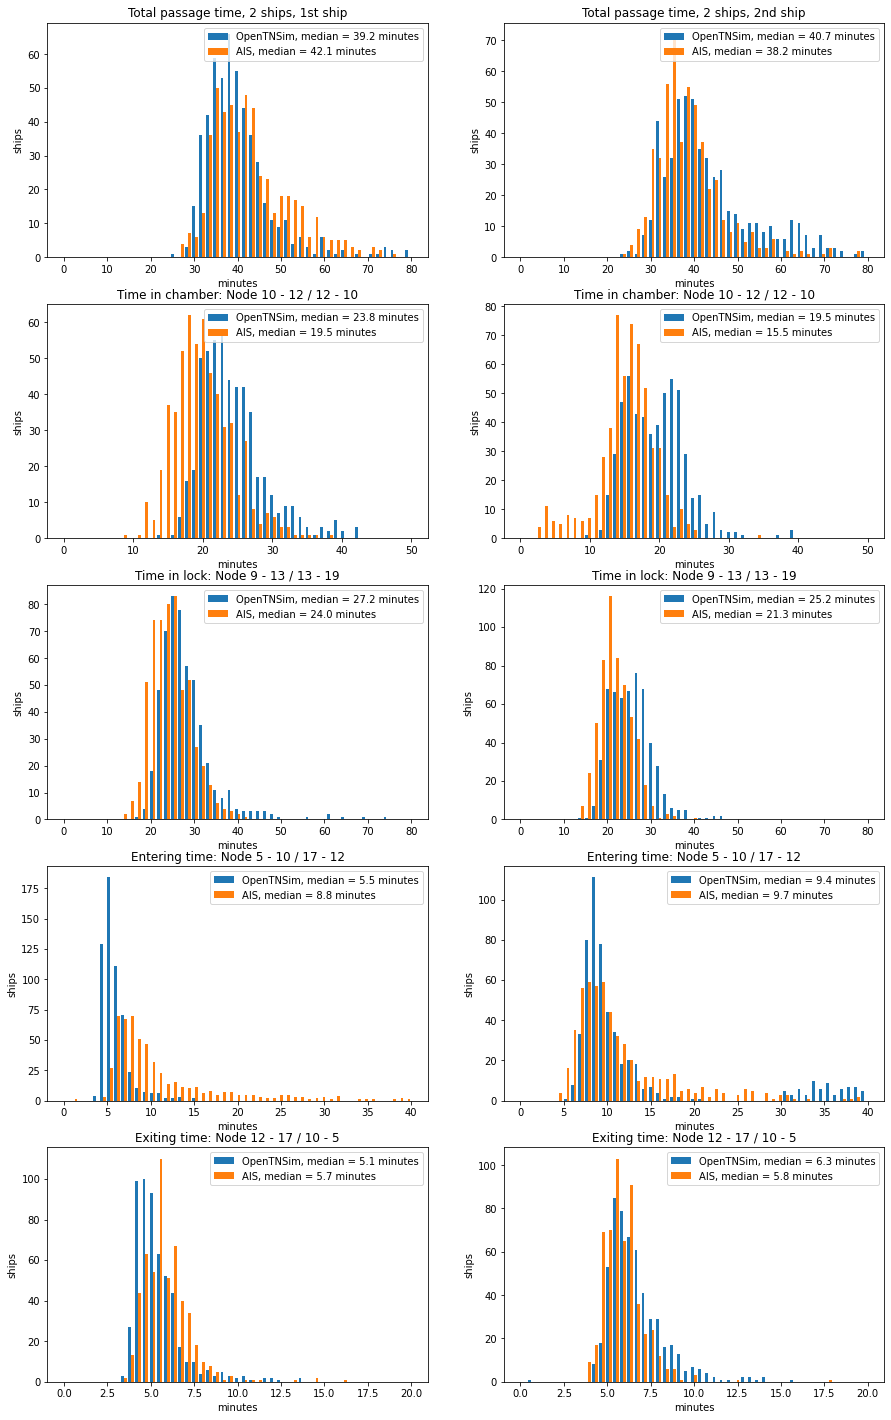

In [22]:
fig, axs = plt.subplots(5, 2, figsize=(15,25))

titles = ['Total passage time, 2 ships, 1st ship', 'Time in chamber: Node 10 - 12 / 12 - 10', 'Time in lock: Node 9 - 13 / 13 - 19',
         'Entering time: Node 5 - 10 / 17 - 12', 'Exiting time: Node 12 - 17 / 10 - 5']

limits = [[0, 80], [0, 50], [0, 80], [0, 40], [0, 20]]

node_1 = [[1, 21], [10, 12], [9, 13], [5, 17], [12, 10]]
node_2 = [[21, 1], [12, 10], [13, 9], [10, 12], [17, 5]]

vessels_plot = np.array(vessels)[:,0]
vessels_plot_ais = ship_nodes_1[0]

for i, ax in enumerate(axs[:,0]):
    
    node_times_plot = node_times(vessels_plot, node_1[i], node_2[i])
    node_times_ais_plot = node_times_ais(vessels_plot_ais, node_1[i], node_2[i])
    
    ax.hist([node_times_plot / 60, node_times_ais_plot / 60], bins=np.linspace(limits[i][0], limits[i][1], 50))
    ax.set(title=titles[i], xlabel='minutes', ylabel='ships');
    ax.legend([f'OpenTNSim, median = {round(np.median(node_times_plot / 60), 1)} minutes', f'AIS, median = {round(np.median(node_times_ais_plot / 60), 1)} minutes'])
    
titles = ['Total passage time, 2 ships, 2nd ship', 'Time in chamber: Node 10 - 12 / 12 - 10', 'Time in lock: Node 9 - 13 / 13 - 19',
         'Entering time: Node 5 - 10 / 17 - 12', 'Exiting time: Node 12 - 17 / 10 - 5']

limits = [[0, 80], [0, 50], [0, 80], [0, 40], [0, 20]]

node_1 = [[1, 21], [10, 12], [9, 13], [5, 17], [12, 10]]
node_2 = [[21, 1], [12, 10], [13, 9], [10, 12], [17, 5]]

vessels_plot = np.array(vessels)[:,2]
vessels_plot_ais = ship_nodes_1[1]

for i, ax in enumerate(axs[:,1]):
    
    node_times_plot = node_times(vessels_plot, node_1[i], node_2[i])
    node_times_ais_plot = node_times_ais(vessels_plot_ais, node_1[i], node_2[i])
    
    ax.hist([node_times_plot / 60, node_times_ais_plot / 60], bins=np.linspace(limits[i][0], limits[i][1], 50))
    ax.set(title=titles[i], xlabel='minutes', ylabel='ships');
    ax.legend([f'OpenTNSim, median = {round(np.median(node_times_plot / 60), 1)} minutes', f'AIS, median = {round(np.median(node_times_ais_plot / 60), 1)} minutes'])

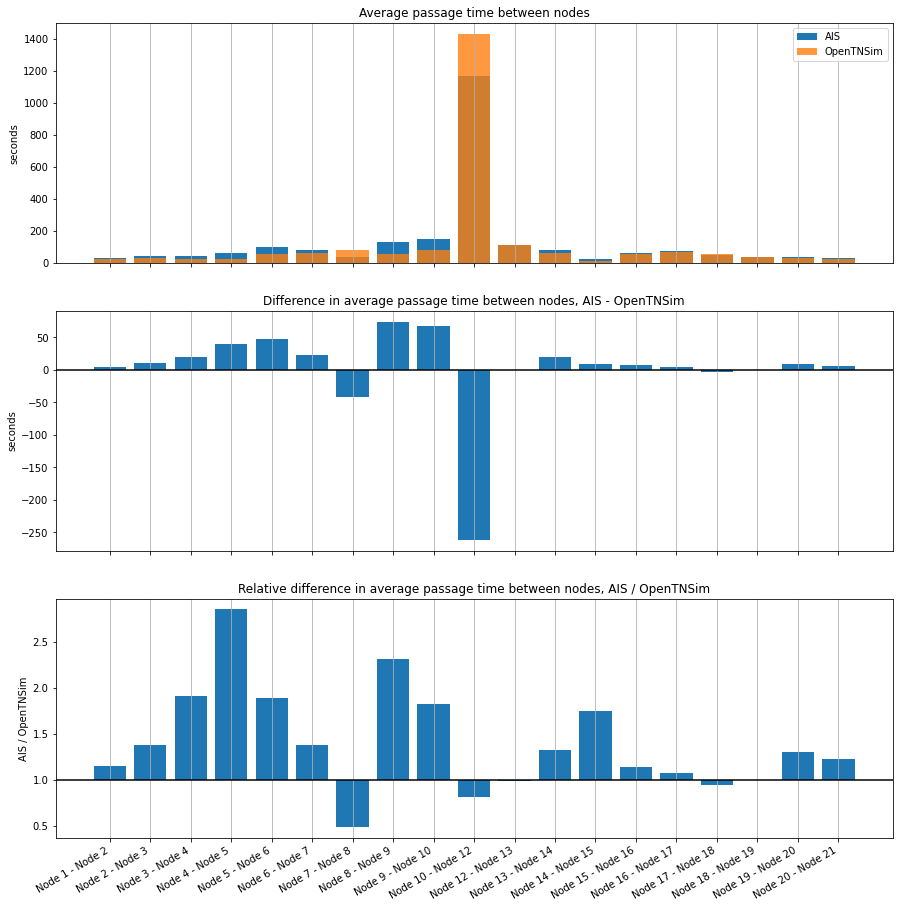

In [23]:
# Get node times with 1 node increments

node_numbers = np.arange(1, 22, 1)
node_numbers_reverse = np.arange(21, 0, -1)

# Node 11 is skipped because the location in the lock can be closer to node 10 or 12 for the AIS data.
node_numbers = node_numbers[node_numbers != 11]
node_numbers_reverse = node_numbers_reverse[node_numbers_reverse != 11]


vessels_plot = np.array(vessels)[:,0]
vessels_plot_ais = ship_nodes_1[0]

node_times_plot = []
node_times_plot_ais = []

x_labels = []

for i in range(len(node_numbers) - 1):
    node_1 = [node_numbers[i], node_numbers_reverse[i]]
    node_2 = [node_numbers[i + 1], node_numbers_reverse[i + 1]]
    
    node_times_plot.append(np.median(node_times(vessels_plot, node_1, node_2)))
    node_times_plot_ais.append(np.median(node_times_ais(vessels_plot_ais, node_1, node_2)))

    x_label = f'Node {node_numbers[i]} - Node {node_numbers[i + 1]}'
    x_labels.append(x_label)

fig, axs = plt.subplots(3, 1, figsize=(15, 15))
x_ticks = np.arange(1, 20, 1)

node_times_plot = np.array(node_times_plot)
node_times_plot_ais = np.array(node_times_plot_ais)

ax = axs[0]
ax.bar(x_ticks, node_times_plot_ais)
ax.bar(x_ticks, node_times_plot, alpha=.8)

ax.set(xticks=x_ticks, xticklabels=[], title='Average passage time between nodes', ylabel='seconds');
ax.legend(['AIS', 'OpenTNSim'])
ax.grid(True, axis='x')

ax = axs[1]
ax.bar(x_ticks, node_times_plot_ais - node_times_plot)
ax.axhline(0, color='k')

ax.set(xticks=x_ticks, xticklabels=[], title='Difference in average passage time between nodes, AIS - OpenTNSim', ylabel='seconds');
ax.grid(True, axis='x')

ax = axs[2]
ax.bar(x_ticks, node_times_plot_ais / node_times_plot - 1, bottom = 1)
ax.axhline(1, color='k')

ax.set(xticks=x_ticks, xticklabels=x_labels, title='Relative difference in average passage time between nodes, AIS / OpenTNSim', ylabel='AIS / OpenTNSim')
plt.setp(ax.get_xticklabels(), rotation=30, ha="right");
ax.grid(True, axis='x')

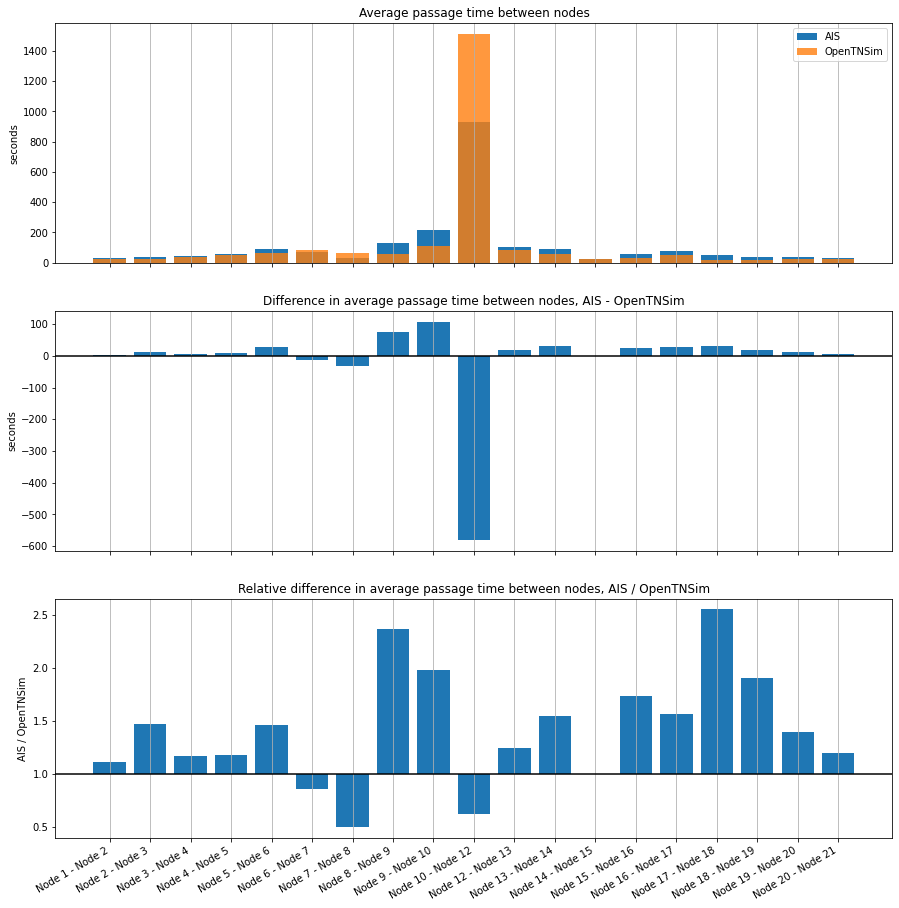

In [25]:
# Get node times with 1 node increments

node_numbers = np.arange(1, 22, 1)
node_numbers_reverse = np.arange(21, 0, -1)

# Node 11 is skipped because the location in the lock can be closer to node 10 or 12 for the AIS data.
node_numbers = node_numbers[node_numbers != 11]
node_numbers_reverse = node_numbers_reverse[node_numbers_reverse != 11]


vessels_plot = np.array(vessels)[:,1]
vessels_plot_ais = ship_nodes_1[1]

node_times_plot = []
node_times_plot_ais = []

x_labels = []

for i in range(len(node_numbers) - 1):
    node_1 = [node_numbers[i], node_numbers_reverse[i]]
    node_2 = [node_numbers[i + 1], node_numbers_reverse[i + 1]]
    
    node_times_plot.append(np.median(node_times(vessels_plot, node_1, node_2)))
    node_times_plot_ais.append(np.median(node_times_ais(vessels_plot_ais, node_1, node_2)))

    x_label = f'Node {node_numbers[i]} - Node {node_numbers[i + 1]}'
    x_labels.append(x_label)

fig, axs = plt.subplots(3, 1, figsize=(15, 15))
x_ticks = np.arange(1, 20, 1)

node_times_plot = np.array(node_times_plot)
node_times_plot_ais = np.array(node_times_plot_ais)

ax = axs[0]
ax.bar(x_ticks, node_times_plot_ais)
ax.bar(x_ticks, node_times_plot, alpha=.8)

ax.set(xticks=x_ticks, xticklabels=[], title='Average passage time between nodes', ylabel='seconds');
ax.legend(['AIS', 'OpenTNSim'])
ax.grid(True, axis='x')

ax = axs[1]
ax.bar(x_ticks, node_times_plot_ais - node_times_plot)
ax.axhline(0, color='k')

ax.set(xticks=x_ticks, xticklabels=[], title='Difference in average passage time between nodes, AIS - OpenTNSim', ylabel='seconds');
ax.grid(True, axis='x')

ax = axs[2]
ax.bar(x_ticks, node_times_plot_ais / node_times_plot - 1, bottom = 1)
ax.axhline(1, color='k')

ax.set(xticks=x_ticks, xticklabels=x_labels, title='Relative difference in average passage time between nodes, AIS / OpenTNSim', ylabel='AIS / OpenTNSim')
plt.setp(ax.get_xticklabels(), rotation=30, ha="right");
ax.grid(True, axis='x')